# REBER Grammar with RNN

In this workbook, we are going to set-up multiple Recurrent Neural Network to test them using as test <a href="https://www.willamette.edu/~gorr/classes/cs449/reber.html" target="_blank">Reber's grammar</a> words.

## What is a Reber Word ?

A Reber word is a word following the Reber's grammar. The grammar is based on the following graph:

<img src="reber.gif"/>

The word must start with B, then it can be either T or P and so on until it reaches E. To prepare data for this, we are going to use a OneHotEncoder to have 7 inputs, n timesteps (depending on the length of the word) and k batches. To generate it, I use the algorith from <a href="http://christianherta.de/lehre/dataScience/machineLearning/neuralNetworks/reberGrammar.php" target="_target">this site</a>

It also exists an Embedded version of the Reber Grammar using the following graph :

<img src="embreber.gif"/>

For now, we gonna focus on the simple version and based on the result, we may try the embedded version.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import seaborn as sns

import create_dataset as reber

from keras.datasets import imdb
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.layers import LSTM, SimpleRNN, GRU
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.callbacks import ModelCheckpoint, EarlyStopping

np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

%matplotlib inline

Using TensorFlow backend.


## Preparation of datas

For the OneHotEncoder, the chain 'BTSXPVE' will be used. We can now try only 1 example to check the output

In [2]:
x, y = reber.get_one_example(minLength=10)
print(reber.sequenceToWord(x))
print(x[0], y[0])

BTXXTVPXVPS
[ 1.  0.  0.  0.  0.  0.  0.] [ 0.  1.  0.  0.  1.  0.  0.]


*y* is the possible outcome for a given input. That means B ([ 1.  0.  0.  0.  0.  0.  0.]) can be followed by T or P ([ 0.  1.  0.  0.  1.  0.  0.]).

However, we won't use y as output but for every timestep, we are going to provide the next timestep as target. For this, we will use the following function

In [3]:
def generate(x0):
    end = np.array([0.,  0.,  0.,  0.,  0.,  0.,  1.])
    y=x0[1:]
    y.append(end)
    return y

Now, if we take as input "BTSXS", the output will be "TSXSE" (but the input in encoded).

We can also generate few words to check the output.

In [4]:
min_length = 10
for i in range(10):
    inp, out = reber.get_one_example(min_length)
    print(reber.sequenceToWord(inp))

BTSSSSSXXVPS
BPTTTVPXVPXTTTVV
BPTTTVPXVPXVPXTVV
BPTTVPXTVPS
BTXXTVPXVPXVPS
BTSSXXTVPXVV
BTSSSXXVPS
BTXXTVPXVPXTTTTVPS
BPVPXTTTVPXTTVPXVV
BTSXXTTTVV


So we have the first "problem" now, the length of the string is variable. So when we are going to generate our test/train datas, we will have to pad them to the same length (let's say 20). This is done by using <b>sequence.pad_sequences</b> for Keras Library

In [5]:
X_train, y_train = [], []
X_test, y_test = [], []
X_val, y_val = [], []
y_possible = []

for i in range(2048):
    x, y = reber.get_one_example(min_length)
    X_train.append(x)
    y_train.append(generate(x))

for i in range(256):
    x, y = reber.get_one_example(min_length)
    X_test.append(x)
    y_test.append(generate(x))  
    
for i in range(1):
    x, y = reber.get_one_example(min_length)
    X_val.append(x)
    y_val.append(generate(x))
    y_possible.append(y)

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
X_val = np.array(X_val)
y_val = np.array(y_val)
y_possible = np.array(y_possible)

maxlen = 20
X_train = sequence.pad_sequences(X_train, maxlen=maxlen, padding='post', truncating='post')
y_train = sequence.pad_sequences(y_train, maxlen=maxlen, padding='post', truncating='post')
X_test = sequence.pad_sequences(X_test, maxlen=maxlen, padding='post', truncating='post')
y_test = sequence.pad_sequences(y_test, maxlen=maxlen, padding='post', truncating='post')
X_val = sequence.pad_sequences(X_val, maxlen=maxlen, padding='post', truncating='post')
y_val = sequence.pad_sequences(y_val, maxlen=maxlen, padding='post', truncating='post')
y_possible = sequence.pad_sequences(y_possible, maxlen=maxlen, padding='post', truncating='post')

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_val.shape)
print(y_val.shape)
print(y_possible.shape)

(2048, 20, 7)
(2048, 20, 7)
(256, 20, 7)
(256, 20, 7)
(1, 20, 7)
(1, 20, 7)
(1, 20, 7)


In [6]:
print(y_possible)

[[[0 1 0 0 1 0 0]
  [0 0 1 1 0 0 0]
  [0 0 1 1 0 0 0]
  [0 1 0 0 0 1 0]
  [0 1 0 0 0 1 0]
  [0 0 0 0 1 1 0]
  [0 0 1 1 0 0 0]
  [0 1 0 0 0 1 0]
  [0 0 0 0 1 1 0]
  [0 0 1 1 0 0 0]
  [0 1 0 0 0 1 0]
  [0 1 0 0 0 1 0]
  [0 0 0 0 1 1 0]
  [0 0 1 1 0 0 0]
  [0 1 0 0 0 1 0]
  [0 0 0 0 1 1 0]
  [0 0 0 0 0 0 1]
  [0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0]]]


So now we have 2048 strings for training, 256 for test and 1 just for visualisation later. We can now set-up our model.

## Test of RNNs

For this model, we are going to use a many-to-many RNN. That means for every input, the model will predict an output. The training will be done based on the input we prepared previously. Once trained. We will be able to "transfer" the learning to a one-to-many model in order to have a "generator".

<img src="RNN_types.jpg"/>

During the writing of this notebook, I tried some loss, metrics and optimizer. The following ones are the one fitting the best

In [15]:
nb_unit = 7
inp_shape = (maxlen, 7)
loss_ = "categorical_crossentropy"
metrics_ = "categorical_crossentropy"
optimizer_ = "Nadam"
nb_epoch = 250
batch_size = 64

### LSTM

The first model we will setup is an <b>LSTM</b> which means <b>L</b>ong <b>S</b>hort-<b>T</b>erm <b>M</b>emory. The principle is 
quite complex but very powerfull for long sequences inputs (because there is less issues with Vanishing Gradient Problem) or long term memory (You can refer to <a href="http://colah.github.io/posts/2015-08-Understanding-LSTMs/" target="_blank">this link</a> for more informations)

LSTM is widely for speech recognition, Natural Language processing, Sentiment Analysis.

In [43]:
model = Sequential()

model.add(LSTM(units=nb_unit, input_shape=inp_shape, return_sequences=True, activation='softmax'))  # single LSTM
model.compile(loss=loss_,
              optimizer=optimizer_,
              metrics=[metrics_])

checkpoint = ModelCheckpoint("lstm_simple.h5",
    monitor=loss_,
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    period=1)
early = EarlyStopping(
    monitor='loss',
    min_delta=0,
    patience=10,
    verbose=1,
    mode='auto')

In [44]:
print("Inputs: {}".format(model.input_shape))
print("Outputs: {}".format(model.output_shape))
print("Actual input: {}".format(X_train.shape))
print("Actual output: {}".format(y_train.shape))

Inputs: (None, 20, 7)
Outputs: (None, 20, 7)
Actual input: (2048, 20, 7)
Actual output: (2048, 20, 7)


In [45]:
start = time.time()
history = model.fit(X_train, y_train, 
                    validation_data=(X_test, y_test), 
                    epochs=nb_epoch, 
                    batch_size=batch_size, 
                    verbose=2, 
                    callbacks = [checkpoint, early])
stop = time.time()
t1 = stop-start
print(model.summary())
print("Training time : {}s".format(t1))

Train on 2048 samples, validate on 256 samples
Epoch 1/250
Epoch 00001: categorical_crossentropy improved from inf to 1.22591, saving model to lstm_simple.h5
 - 3s - loss: 1.2259 - categorical_crossentropy: 1.2259 - val_loss: 1.2533 - val_categorical_crossentropy: 1.2533
Epoch 2/250
Epoch 00002: categorical_crossentropy improved from 1.22591 to 1.17858, saving model to lstm_simple.h5
 - 2s - loss: 1.1786 - categorical_crossentropy: 1.1786 - val_loss: 1.2060 - val_categorical_crossentropy: 1.2060
Epoch 3/250
Epoch 00003: categorical_crossentropy improved from 1.17858 to 1.13519, saving model to lstm_simple.h5
 - 2s - loss: 1.1352 - categorical_crossentropy: 1.1352 - val_loss: 1.1637 - val_categorical_crossentropy: 1.1637
Epoch 4/250
Epoch 00004: categorical_crossentropy improved from 1.13519 to 1.09620, saving model to lstm_simple.h5
 - 2s - loss: 1.0962 - categorical_crossentropy: 1.0962 - val_loss: 1.1260 - val_categorical_crossentropy: 1.1260
Epoch 5/250
Epoch 00005: categorical_cros

Epoch 37/250
Epoch 00037: categorical_crossentropy improved from 0.50916 to 0.50457, saving model to lstm_simple.h5
 - 2s - loss: 0.5046 - categorical_crossentropy: 0.5046 - val_loss: 0.5181 - val_categorical_crossentropy: 0.5181
Epoch 38/250
Epoch 00038: categorical_crossentropy improved from 0.50457 to 0.50038, saving model to lstm_simple.h5
 - 2s - loss: 0.5004 - categorical_crossentropy: 0.5004 - val_loss: 0.5144 - val_categorical_crossentropy: 0.5144
Epoch 39/250
Epoch 00039: categorical_crossentropy improved from 0.50038 to 0.49642, saving model to lstm_simple.h5
 - 2s - loss: 0.4964 - categorical_crossentropy: 0.4964 - val_loss: 0.5105 - val_categorical_crossentropy: 0.5105
Epoch 40/250
Epoch 00040: categorical_crossentropy improved from 0.49642 to 0.49262, saving model to lstm_simple.h5
 - 2s - loss: 0.4926 - categorical_crossentropy: 0.4926 - val_loss: 0.5068 - val_categorical_crossentropy: 0.5068
Epoch 41/250
Epoch 00041: categorical_crossentropy improved from 0.49262 to 0.48

Epoch 73/250
Epoch 00073: categorical_crossentropy improved from 0.41231 to 0.41079, saving model to lstm_simple.h5
 - 2s - loss: 0.4108 - categorical_crossentropy: 0.4108 - val_loss: 0.4264 - val_categorical_crossentropy: 0.4264
Epoch 74/250
Epoch 00074: categorical_crossentropy improved from 0.41079 to 0.41000, saving model to lstm_simple.h5
 - 2s - loss: 0.4100 - categorical_crossentropy: 0.4100 - val_loss: 0.4257 - val_categorical_crossentropy: 0.4257
Epoch 75/250
Epoch 00075: categorical_crossentropy improved from 0.41000 to 0.40842, saving model to lstm_simple.h5
 - 2s - loss: 0.4084 - categorical_crossentropy: 0.4084 - val_loss: 0.4240 - val_categorical_crossentropy: 0.4240
Epoch 76/250
Epoch 00076: categorical_crossentropy improved from 0.40842 to 0.40708, saving model to lstm_simple.h5
 - 2s - loss: 0.4071 - categorical_crossentropy: 0.4071 - val_loss: 0.4222 - val_categorical_crossentropy: 0.4222
Epoch 77/250
Epoch 00077: categorical_crossentropy improved from 0.40708 to 0.40

Epoch 110/250
Epoch 00110: categorical_crossentropy improved from 0.37769 to 0.37746, saving model to lstm_simple.h5
 - 2s - loss: 0.3775 - categorical_crossentropy: 0.3775 - val_loss: 0.3987 - val_categorical_crossentropy: 0.3987
Epoch 111/250
Epoch 00111: categorical_crossentropy did not improve
 - 2s - loss: 0.3783 - categorical_crossentropy: 0.3783 - val_loss: 0.3969 - val_categorical_crossentropy: 0.3969
Epoch 112/250
Epoch 00112: categorical_crossentropy did not improve
 - 2s - loss: 0.3775 - categorical_crossentropy: 0.3775 - val_loss: 0.3943 - val_categorical_crossentropy: 0.3943
Epoch 113/250
Epoch 00113: categorical_crossentropy improved from 0.37746 to 0.37701, saving model to lstm_simple.h5
 - 2s - loss: 0.3770 - categorical_crossentropy: 0.3770 - val_loss: 0.3946 - val_categorical_crossentropy: 0.3946
Epoch 114/250
Epoch 00114: categorical_crossentropy improved from 0.37701 to 0.37673, saving model to lstm_simple.h5
 - 2s - loss: 0.3767 - categorical_crossentropy: 0.3767 -

In [28]:
LSTM_steps = 90

## Simple RNN

Using the same code, we can train the standard RNN. The principle is that every output of every hidden layers, are also feed as entry for the next step

<img src="SimpleRNN.png"/>

This allows a "short term memory". It creates a kind of hysteresis used as memory

In [23]:
model2 = Sequential()
model2.add(SimpleRNN(units=nb_unit, input_shape=inp_shape, return_sequences=True, activation='softmax'))
model2.compile(loss=loss_,
              optimizer=optimizer_,
              metrics=[metrics_])

checkpoint = ModelCheckpoint("srnn_simple.h5",
    monitor=loss_,
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    period=1)
early = EarlyStopping(
    monitor='loss',
    min_delta=0,
    patience=10,
    verbose=1,
    mode='auto')

In [24]:
start = time.time()
history2 = model2.fit(X_train, y_train, 
                    validation_data=(X_test, y_test), 
                    epochs=nb_epoch, 
                    batch_size=batch_size, 
                    verbose=2, 
                    callbacks = [checkpoint, early])
stop = time.time()
t2 = stop-start
print(model2.summary(), end=" ")
print("Training time : {}s".format(t2))

Train on 2048 samples, validate on 256 samples
Epoch 1/250
Epoch 00001: categorical_crossentropy improved from inf to 1.21966, saving model to srnn_simple.h5
 - 1s - loss: 1.2197 - categorical_crossentropy: 1.2197 - val_loss: 1.2300 - val_categorical_crossentropy: 1.2300
Epoch 2/250
Epoch 00002: categorical_crossentropy improved from 1.21966 to 1.14588, saving model to srnn_simple.h5
 - 1s - loss: 1.1459 - categorical_crossentropy: 1.1459 - val_loss: 1.1620 - val_categorical_crossentropy: 1.1620
Epoch 3/250
Epoch 00003: categorical_crossentropy improved from 1.14588 to 1.08776, saving model to srnn_simple.h5
 - 1s - loss: 1.0878 - categorical_crossentropy: 1.0878 - val_loss: 1.1087 - val_categorical_crossentropy: 1.1087
Epoch 4/250
Epoch 00004: categorical_crossentropy improved from 1.08776 to 1.04124, saving model to srnn_simple.h5
 - 1s - loss: 1.0412 - categorical_crossentropy: 1.0412 - val_loss: 1.0644 - val_categorical_crossentropy: 1.0644
Epoch 5/250
Epoch 00005: categorical_cros

Epoch 37/250
Epoch 00037: categorical_crossentropy improved from 0.50613 to 0.50040, saving model to srnn_simple.h5
 - 1s - loss: 0.5004 - categorical_crossentropy: 0.5004 - val_loss: 0.5134 - val_categorical_crossentropy: 0.5134
Epoch 38/250
Epoch 00038: categorical_crossentropy improved from 0.50040 to 0.49502, saving model to srnn_simple.h5
 - 1s - loss: 0.4950 - categorical_crossentropy: 0.4950 - val_loss: 0.5081 - val_categorical_crossentropy: 0.5081
Epoch 39/250
Epoch 00039: categorical_crossentropy improved from 0.49502 to 0.48997, saving model to srnn_simple.h5
 - 1s - loss: 0.4900 - categorical_crossentropy: 0.4900 - val_loss: 0.5031 - val_categorical_crossentropy: 0.5031
Epoch 40/250
Epoch 00040: categorical_crossentropy improved from 0.48997 to 0.48525, saving model to srnn_simple.h5
 - 1s - loss: 0.4853 - categorical_crossentropy: 0.4853 - val_loss: 0.4984 - val_categorical_crossentropy: 0.4984
Epoch 41/250
Epoch 00041: categorical_crossentropy improved from 0.48525 to 0.48

Epoch 73/250
Epoch 00073: categorical_crossentropy improved from 0.41259 to 0.41151, saving model to srnn_simple.h5
 - 1s - loss: 0.4115 - categorical_crossentropy: 0.4115 - val_loss: 0.4248 - val_categorical_crossentropy: 0.4248
Epoch 74/250
Epoch 00074: categorical_crossentropy improved from 0.41151 to 0.41047, saving model to srnn_simple.h5
 - 1s - loss: 0.4105 - categorical_crossentropy: 0.4105 - val_loss: 0.4238 - val_categorical_crossentropy: 0.4238
Epoch 75/250
Epoch 00075: categorical_crossentropy improved from 0.41047 to 0.40947, saving model to srnn_simple.h5
 - 1s - loss: 0.4095 - categorical_crossentropy: 0.4095 - val_loss: 0.4228 - val_categorical_crossentropy: 0.4228
Epoch 76/250
Epoch 00076: categorical_crossentropy improved from 0.40947 to 0.40848, saving model to srnn_simple.h5
 - 1s - loss: 0.4085 - categorical_crossentropy: 0.4085 - val_loss: 0.4218 - val_categorical_crossentropy: 0.4218
Epoch 77/250
Epoch 00077: categorical_crossentropy improved from 0.40848 to 0.40

Epoch 109/250
Epoch 00109: categorical_crossentropy improved from 0.38815 to 0.38774, saving model to srnn_simple.h5
 - 1s - loss: 0.3877 - categorical_crossentropy: 0.3877 - val_loss: 0.4016 - val_categorical_crossentropy: 0.4016
Epoch 110/250
Epoch 00110: categorical_crossentropy improved from 0.38774 to 0.38733, saving model to srnn_simple.h5
 - 1s - loss: 0.3873 - categorical_crossentropy: 0.3873 - val_loss: 0.4011 - val_categorical_crossentropy: 0.4011
Epoch 111/250
Epoch 00111: categorical_crossentropy improved from 0.38733 to 0.38693, saving model to srnn_simple.h5
 - 1s - loss: 0.3869 - categorical_crossentropy: 0.3869 - val_loss: 0.4007 - val_categorical_crossentropy: 0.4007
Epoch 112/250
Epoch 00112: categorical_crossentropy improved from 0.38693 to 0.38654, saving model to srnn_simple.h5
 - 1s - loss: 0.3865 - categorical_crossentropy: 0.3865 - val_loss: 0.4004 - val_categorical_crossentropy: 0.4004
Epoch 113/250
Epoch 00113: categorical_crossentropy improved from 0.38654 to

Epoch 145/250
Epoch 00145: categorical_crossentropy improved from 0.37723 to 0.37698, saving model to srnn_simple.h5
 - 1s - loss: 0.3770 - categorical_crossentropy: 0.3770 - val_loss: 0.3911 - val_categorical_crossentropy: 0.3911
Epoch 146/250
Epoch 00146: categorical_crossentropy improved from 0.37698 to 0.37682, saving model to srnn_simple.h5
 - 1s - loss: 0.3768 - categorical_crossentropy: 0.3768 - val_loss: 0.3909 - val_categorical_crossentropy: 0.3909
Epoch 147/250
Epoch 00147: categorical_crossentropy improved from 0.37682 to 0.37656, saving model to srnn_simple.h5
 - 1s - loss: 0.3766 - categorical_crossentropy: 0.3766 - val_loss: 0.3909 - val_categorical_crossentropy: 0.3909
Epoch 148/250
Epoch 00148: categorical_crossentropy improved from 0.37656 to 0.37633, saving model to srnn_simple.h5
 - 1s - loss: 0.3763 - categorical_crossentropy: 0.3763 - val_loss: 0.3905 - val_categorical_crossentropy: 0.3905
Epoch 149/250
Epoch 00149: categorical_crossentropy improved from 0.37633 to

Epoch 181/250
Epoch 00181: categorical_crossentropy improved from 0.36828 to 0.36803, saving model to srnn_simple.h5
 - 1s - loss: 0.3680 - categorical_crossentropy: 0.3680 - val_loss: 0.3821 - val_categorical_crossentropy: 0.3821
Epoch 182/250
Epoch 00182: categorical_crossentropy improved from 0.36803 to 0.36770, saving model to srnn_simple.h5
 - 1s - loss: 0.3677 - categorical_crossentropy: 0.3677 - val_loss: 0.3819 - val_categorical_crossentropy: 0.3819
Epoch 183/250
Epoch 00183: categorical_crossentropy improved from 0.36770 to 0.36742, saving model to srnn_simple.h5
 - 1s - loss: 0.3674 - categorical_crossentropy: 0.3674 - val_loss: 0.3822 - val_categorical_crossentropy: 0.3822
Epoch 184/250
Epoch 00184: categorical_crossentropy improved from 0.36742 to 0.36720, saving model to srnn_simple.h5
 - 1s - loss: 0.3672 - categorical_crossentropy: 0.3672 - val_loss: 0.3813 - val_categorical_crossentropy: 0.3813
Epoch 185/250
Epoch 00185: categorical_crossentropy improved from 0.36720 to

Epoch 217/250
Epoch 00217: categorical_crossentropy did not improve
 - 1s - loss: 0.3618 - categorical_crossentropy: 0.3618 - val_loss: 0.3762 - val_categorical_crossentropy: 0.3762
Epoch 218/250
Epoch 00218: categorical_crossentropy improved from 0.36182 to 0.36171, saving model to srnn_simple.h5
 - 1s - loss: 0.3617 - categorical_crossentropy: 0.3617 - val_loss: 0.3756 - val_categorical_crossentropy: 0.3756
Epoch 219/250
Epoch 00219: categorical_crossentropy improved from 0.36171 to 0.36154, saving model to srnn_simple.h5
 - 1s - loss: 0.3615 - categorical_crossentropy: 0.3615 - val_loss: 0.3756 - val_categorical_crossentropy: 0.3756
Epoch 220/250
Epoch 00220: categorical_crossentropy did not improve
 - 1s - loss: 0.3616 - categorical_crossentropy: 0.3616 - val_loss: 0.3762 - val_categorical_crossentropy: 0.3762
Epoch 221/250
Epoch 00221: categorical_crossentropy improved from 0.36154 to 0.36140, saving model to srnn_simple.h5
 - 1s - loss: 0.3614 - categorical_crossentropy: 0.3614 -

In [29]:
SRNN_steps = 250

## GRU

Finally, we can train a <b>GRU</b> (<b>G</b>ated <b>R</b>ecurrent <b>U</b>nits). It's a simplification of LSTMs. They also have a memory mechanism but with less parameters. As a result they are faster to train. You can find differences on <a href="https://datascience.stackexchange.com/questions/14581/what-is-difference-between-gru-and-lstm" target="_blank">this topic</a> 

In [25]:
model3 = Sequential()
model3.add(GRU(units=nb_unit, input_shape=inp_shape, return_sequences=True, activation='softmax'))
model3.compile(loss=loss_,
              optimizer=optimizer_,
              metrics=[metrics_])

checkpoint = ModelCheckpoint("gru_simple.h5",
    monitor=loss_,
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    period=1)
early = EarlyStopping(
    monitor='loss',
    min_delta=0,
    patience=10,
    verbose=1,
    mode='auto')

In [26]:
start = time.time()
history3 = model3.fit(X_train, y_train, 
                    validation_data=(X_test, y_test), 
                    epochs=nb_epoch, 
                    batch_size=batch_size, 
                    verbose=2, 
                    callbacks = [checkpoint, early])
stop = time.time()
t3 = stop-start
print(model3.summary(), end=" ")
print("Training time : {}s".format(t3))

Train on 2048 samples, validate on 256 samples
Epoch 1/250
Epoch 00001: categorical_crossentropy improved from inf to 1.22655, saving model to gru_simple.h5
 - 2s - loss: 1.2266 - categorical_crossentropy: 1.2266 - val_loss: 1.2455 - val_categorical_crossentropy: 1.2455
Epoch 2/250
Epoch 00002: categorical_crossentropy improved from 1.22655 to 1.16774, saving model to gru_simple.h5
 - 1s - loss: 1.1677 - categorical_crossentropy: 1.1677 - val_loss: 1.1880 - val_categorical_crossentropy: 1.1880
Epoch 3/250
Epoch 00003: categorical_crossentropy improved from 1.16774 to 1.11684, saving model to gru_simple.h5
 - 1s - loss: 1.1168 - categorical_crossentropy: 1.1168 - val_loss: 1.1385 - val_categorical_crossentropy: 1.1385
Epoch 4/250
Epoch 00004: categorical_crossentropy improved from 1.11684 to 1.07207, saving model to gru_simple.h5
 - 1s - loss: 1.0721 - categorical_crossentropy: 1.0721 - val_loss: 1.0937 - val_categorical_crossentropy: 1.0937
Epoch 5/250
Epoch 00005: categorical_crossent

Epoch 37/250
Epoch 00037: categorical_crossentropy improved from 0.42185 to 0.41864, saving model to gru_simple.h5
 - 1s - loss: 0.4186 - categorical_crossentropy: 0.4186 - val_loss: 0.4331 - val_categorical_crossentropy: 0.4331
Epoch 38/250
Epoch 00038: categorical_crossentropy improved from 0.41864 to 0.41571, saving model to gru_simple.h5
 - 1s - loss: 0.4157 - categorical_crossentropy: 0.4157 - val_loss: 0.4304 - val_categorical_crossentropy: 0.4304
Epoch 39/250
Epoch 00039: categorical_crossentropy improved from 0.41571 to 0.41299, saving model to gru_simple.h5
 - 1s - loss: 0.4130 - categorical_crossentropy: 0.4130 - val_loss: 0.4278 - val_categorical_crossentropy: 0.4278
Epoch 40/250
Epoch 00040: categorical_crossentropy improved from 0.41299 to 0.41050, saving model to gru_simple.h5
 - 1s - loss: 0.4105 - categorical_crossentropy: 0.4105 - val_loss: 0.4254 - val_categorical_crossentropy: 0.4254
Epoch 41/250
Epoch 00041: categorical_crossentropy improved from 0.41050 to 0.40823,

Epoch 73/250
Epoch 00073: categorical_crossentropy improved from 0.37562 to 0.37512, saving model to gru_simple.h5
 - 1s - loss: 0.3751 - categorical_crossentropy: 0.3751 - val_loss: 0.3904 - val_categorical_crossentropy: 0.3904
Epoch 74/250
Epoch 00074: categorical_crossentropy improved from 0.37512 to 0.37465, saving model to gru_simple.h5
 - 1s - loss: 0.3746 - categorical_crossentropy: 0.3746 - val_loss: 0.3899 - val_categorical_crossentropy: 0.3899
Epoch 75/250
Epoch 00075: categorical_crossentropy improved from 0.37465 to 0.37419, saving model to gru_simple.h5
 - 1s - loss: 0.3742 - categorical_crossentropy: 0.3742 - val_loss: 0.3894 - val_categorical_crossentropy: 0.3894
Epoch 76/250
Epoch 00076: categorical_crossentropy improved from 0.37419 to 0.37375, saving model to gru_simple.h5
 - 1s - loss: 0.3737 - categorical_crossentropy: 0.3737 - val_loss: 0.3890 - val_categorical_crossentropy: 0.3890
Epoch 77/250
Epoch 00077: categorical_crossentropy improved from 0.37375 to 0.37330,

Epoch 109/250
Epoch 00109: categorical_crossentropy improved from 0.36475 to 0.36457, saving model to gru_simple.h5
 - 1s - loss: 0.3646 - categorical_crossentropy: 0.3646 - val_loss: 0.3797 - val_categorical_crossentropy: 0.3797
Epoch 110/250
Epoch 00110: categorical_crossentropy improved from 0.36457 to 0.36440, saving model to gru_simple.h5
 - 1s - loss: 0.3644 - categorical_crossentropy: 0.3644 - val_loss: 0.3795 - val_categorical_crossentropy: 0.3795
Epoch 111/250
Epoch 00111: categorical_crossentropy improved from 0.36440 to 0.36423, saving model to gru_simple.h5
 - 1s - loss: 0.3642 - categorical_crossentropy: 0.3642 - val_loss: 0.3793 - val_categorical_crossentropy: 0.3793
Epoch 112/250
Epoch 00112: categorical_crossentropy improved from 0.36423 to 0.36408, saving model to gru_simple.h5
 - 1s - loss: 0.3641 - categorical_crossentropy: 0.3641 - val_loss: 0.3792 - val_categorical_crossentropy: 0.3792
Epoch 113/250
Epoch 00113: categorical_crossentropy improved from 0.36408 to 0.3

Epoch 145/250
Epoch 00145: categorical_crossentropy improved from 0.36016 to 0.36006, saving model to gru_simple.h5
 - 1s - loss: 0.3601 - categorical_crossentropy: 0.3601 - val_loss: 0.3756 - val_categorical_crossentropy: 0.3756
Epoch 146/250
Epoch 00146: categorical_crossentropy improved from 0.36006 to 0.35999, saving model to gru_simple.h5
 - 1s - loss: 0.3600 - categorical_crossentropy: 0.3600 - val_loss: 0.3754 - val_categorical_crossentropy: 0.3754
Epoch 147/250
Epoch 00147: categorical_crossentropy improved from 0.35999 to 0.35988, saving model to gru_simple.h5
 - 1s - loss: 0.3599 - categorical_crossentropy: 0.3599 - val_loss: 0.3754 - val_categorical_crossentropy: 0.3754
Epoch 148/250
Epoch 00148: categorical_crossentropy improved from 0.35988 to 0.35978, saving model to gru_simple.h5
 - 1s - loss: 0.3598 - categorical_crossentropy: 0.3598 - val_loss: 0.3754 - val_categorical_crossentropy: 0.3754
Epoch 149/250
Epoch 00149: categorical_crossentropy improved from 0.35978 to 0.3

Epoch 181/250
Epoch 00181: categorical_crossentropy improved from 0.35693 to 0.35684, saving model to gru_simple.h5
 - 1s - loss: 0.3568 - categorical_crossentropy: 0.3568 - val_loss: 0.3727 - val_categorical_crossentropy: 0.3727
Epoch 182/250
Epoch 00182: categorical_crossentropy improved from 0.35684 to 0.35675, saving model to gru_simple.h5
 - 1s - loss: 0.3567 - categorical_crossentropy: 0.3567 - val_loss: 0.3729 - val_categorical_crossentropy: 0.3729
Epoch 183/250
Epoch 00183: categorical_crossentropy improved from 0.35675 to 0.35665, saving model to gru_simple.h5
 - 1s - loss: 0.3567 - categorical_crossentropy: 0.3567 - val_loss: 0.3727 - val_categorical_crossentropy: 0.3727
Epoch 184/250
Epoch 00184: categorical_crossentropy improved from 0.35665 to 0.35659, saving model to gru_simple.h5
 - 1s - loss: 0.3566 - categorical_crossentropy: 0.3566 - val_loss: 0.3727 - val_categorical_crossentropy: 0.3727
Epoch 185/250
Epoch 00185: categorical_crossentropy improved from 0.35659 to 0.3

Epoch 217/250
Epoch 00217: categorical_crossentropy improved from 0.35421 to 0.35415, saving model to gru_simple.h5
 - 1s - loss: 0.3542 - categorical_crossentropy: 0.3542 - val_loss: 0.3713 - val_categorical_crossentropy: 0.3713
Epoch 218/250
Epoch 00218: categorical_crossentropy improved from 0.35415 to 0.35414, saving model to gru_simple.h5
 - 1s - loss: 0.3541 - categorical_crossentropy: 0.3541 - val_loss: 0.3713 - val_categorical_crossentropy: 0.3713
Epoch 219/250
Epoch 00219: categorical_crossentropy improved from 0.35414 to 0.35408, saving model to gru_simple.h5
 - 1s - loss: 0.3541 - categorical_crossentropy: 0.3541 - val_loss: 0.3715 - val_categorical_crossentropy: 0.3715
Epoch 220/250
Epoch 00220: categorical_crossentropy improved from 0.35408 to 0.35402, saving model to gru_simple.h5
 - 1s - loss: 0.3540 - categorical_crossentropy: 0.3540 - val_loss: 0.3714 - val_categorical_crossentropy: 0.3714
Epoch 221/250
Epoch 00221: categorical_crossentropy did not improve
 - 1s - loss

In [31]:
GRU_steps = 250

## Evaluation

We can first check the time used to train them on the same dataset with the same number of epochs.

In [27]:
print("LSTM :       {:.2f}s".format(t1))
print("Simple RNN : {:.2f}s".format(t2))
print("GRU :        {:.2f}s".format(t3))

LSTM :       164.06s
Simple RNN : 181.82s
GRU :        330.12s


We can see that the simple RNN is the fastest to train because there is nearly no impact of provide the output as input. It's only and addtion to do on Matrices. However, LSTM and GRU are slower to train and as expected, GRU trained faster than LSTM. Ze can also check the error of prediction. For this I used a Mean Absolute Error as loss fonction and Mean Squared Error as metrics . I used this loss fonction to have the norm 1 between prediction and real output. With the Means Squared Error, the training would take longer as the loss would be smaller as all outputs are below 1. For the metric, I used it to ease the visualisation.

In [36]:
print("epoch", [LSTM_steps, SRNN_steps, GRU_steps])
print("time", [164.06, 181.82, 330.12])

epoch [90, 250, 250]
time [164.06, 181.82, 330.12]


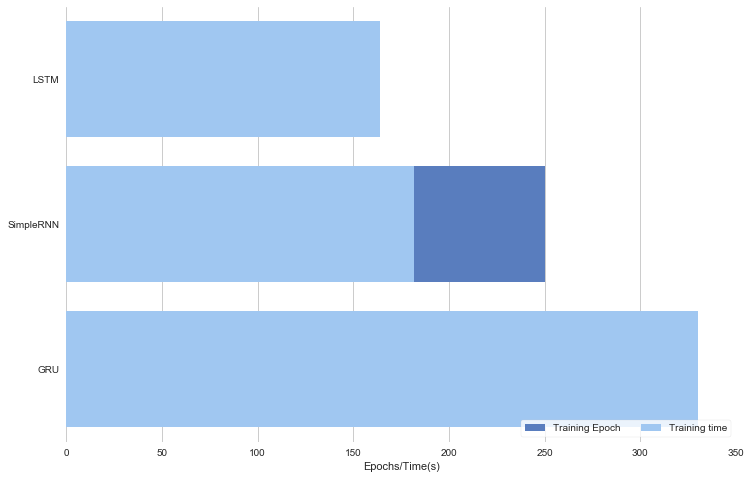

In [34]:
sns.set(style="whitegrid")

f, ax = plt.subplots(figsize=(12, 8))

sns.set_color_codes("muted")
sns.barplot(x=[LSTM_steps, SRNN_steps, GRU_steps], y=["LSTM", "SimpleRNN", "GRU"], label="Training Epoch", color="b")

sns.set_color_codes("pastel")
sns.barplot(x=[t1, t2, t3] , y=["LSTM", "SimpleRNN", "GRU"], label="Training time", color="b")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 350), ylabel="",
       xlabel="Epochs/Time(s)")
sns.despine(left=True, bottom=True)
plt.savefig("barplot_softmax.png")
plt.show()

dict_keys(['val_loss', 'val_categorical_crossentropy', 'loss', 'categorical_crossentropy'])


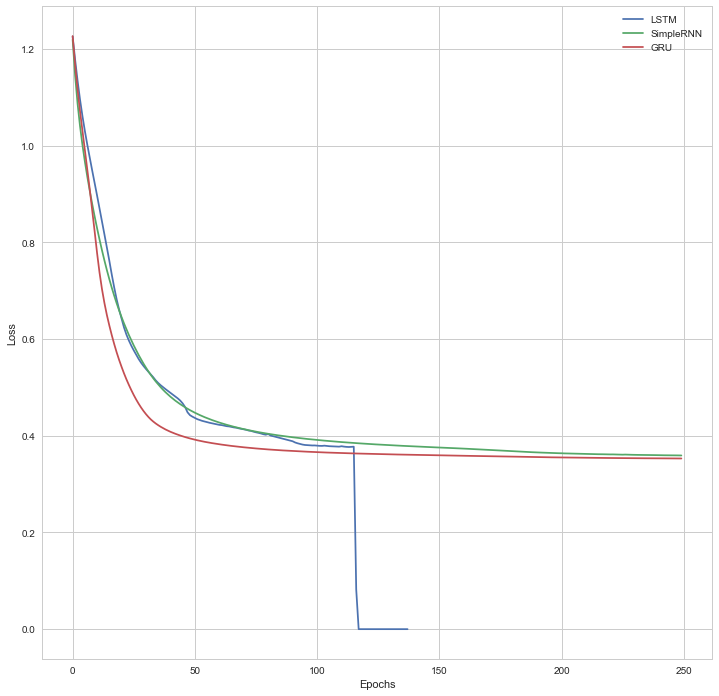

In [46]:
print(history.history.keys())
key_ = list(history.history.keys())[3]
plt.figure(figsize=(12, 12))
plt.plot(history.history[key_], label="LSTM")
plt.plot(history2.history[key_], label="SimpleRNN")
plt.plot(history3.history[key_], label="GRU")
plt.legend()
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.savefig("loss_softmax.png")
plt.show()

We can see that GRU and LSTM perform better than a Simple RNN. LSTM is also performing slightly better that GRU but require more computation time. We can also check the output and compare it to the real output provided by the graph (see the y description in preparation of data section)

In [47]:
print("Input :")
print(X_val)
print("\n\nLSTM predicts :")
y_pred = model.predict(X_val)
print(y_pred)
print("\n\nGRU predicts :")
y_pred = model3.predict(X_val)
print(y_pred)

Input :
[[[1 0 0 0 0 0 0]
  [0 1 0 0 0 0 0]
  [0 0 0 1 0 0 0]
  [0 0 0 1 0 0 0]
  [0 1 0 0 0 0 0]
  [0 0 0 0 0 1 0]
  [0 0 0 0 1 0 0]
  [0 0 0 1 0 0 0]
  [0 0 0 0 0 1 0]
  [0 0 0 0 1 0 0]
  [0 0 0 1 0 0 0]
  [0 1 0 0 0 0 0]
  [0 0 0 0 0 1 0]
  [0 0 0 0 1 0 0]
  [0 0 0 1 0 0 0]
  [0 0 0 0 0 1 0]
  [0 0 0 0 0 1 0]
  [0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0]]]


LSTM predicts :
[[[ nan  nan  nan  nan  nan  nan  nan]
  [ nan  nan  nan  nan  nan  nan  nan]
  [ nan  nan  nan  nan  nan  nan  nan]
  [ nan  nan  nan  nan  nan  nan  nan]
  [ nan  nan  nan  nan  nan  nan  nan]
  [ nan  nan  nan  nan  nan  nan  nan]
  [ nan  nan  nan  nan  nan  nan  nan]
  [ nan  nan  nan  nan  nan  nan  nan]
  [ nan  nan  nan  nan  nan  nan  nan]
  [ nan  nan  nan  nan  nan  nan  nan]
  [ nan  nan  nan  nan  nan  nan  nan]
  [ nan  nan  nan  nan  nan  nan  nan]
  [ nan  nan  nan  nan  nan  nan  nan]
  [ nan  nan  nan  nan  nan  nan  nan]
  [ nan  nan  nan  nan  nan  nan  nan]
  [ nan  nan  nan  nan  nan

We can simply the output by removing small output and compare it to the possible output (we will only keep prediction from GRU)

In [39]:
y_pred = np.where(y_pred < 0.1, 0, y_pred)

In [40]:
for pred, real in zip(y_pred[0], y_possible[0]):
    print(pred, "\t", real)

[ 0.     0.54   0.     0.     0.407  0.     0.   ] 	 [0 1 0 0 1 0 0]
[ 0.     0.     0.66   0.314  0.     0.     0.   ] 	 [0 0 1 1 0 0 0]
[ 0.     0.     0.     0.957  0.     0.     0.   ] 	 [0 0 1 1 0 0 0]
[ 0.     0.628  0.     0.     0.     0.372  0.   ] 	 [0 1 0 0 0 1 0]
[ 0.     0.555  0.     0.     0.     0.372  0.   ] 	 [0 1 0 0 0 1 0]
[ 0.     0.     0.     0.     0.996  0.319  0.   ] 	 [0 0 0 0 1 1 0]
[ 0.     0.     0.167  0.55   0.     0.     0.   ] 	 [0 0 1 1 0 0 0]
[ 0.     0.486  0.     0.     0.     0.51   0.   ] 	 [0 1 0 0 0 1 0]
[ 0.     0.     0.     0.     0.992  0.499  0.   ] 	 [0 0 0 0 1 1 0]
[ 0.     0.     0.301  0.55   0.     0.     0.   ] 	 [0 0 1 1 0 0 0]
[ 0.     0.396  0.     0.     0.     0.592  0.   ] 	 [0 1 0 0 0 1 0]
[ 0.     0.689  0.     0.     0.     0.592  0.   ] 	 [0 1 0 0 0 1 0]
[ 0.     0.     0.     0.     0.997  0.592  0.   ] 	 [0 0 0 0 1 1 0]
[ 0.    0.    0.37  0.55  0.    0.    0.  ] 	 [0 0 1 1 0 0 0]
[ 0.     0.327  0.     0.     0.     0.59

Yeah !! Output is balanced between both offset but with different "probabilities". We can also check how well they are to generate sentences

## Use it as generator

As explained previously, we trained our model as a many-to-many RNN. Now we want a generator so we are going to use a one-to-many model but reusing knowledge from the training. 

Before that, we will need an evaluation function which take the output, pick the next input based on the probability to have this output, create the next input and run it until the graph is over. After that, we will check is the created word is really a Reber word. This will be done with following functions 

In [66]:
def Pick_From_Output(x):
    y = np.zeros_like(x)
    x = np.where(x < 0.1, 0, x)
    x = x[0]/x[0].sum(axis=1)
    i = np.random.choice(list(range(7)), size=1, p=x[0])
    y[0,0,i] = 1
    return y

def evaluate(model, nb_word = 1, max_iter = 50):
    good_pred = 0
    for _ in range(nb_word):
        model.reset_states()
        first_input = np.array([[[1,0,0,0,0,0,0]]])
        word = "B"
        loop = 0
        nextLetter = "B"
        next_seq = first_input
        while nextLetter != "E" and loop < max_iter:
            y_pred = model.predict(next_seq)
            next_seq = Pick_From_Output(y_pred)
            nextLetter = reber.sequenceToWord(next_seq[0])
            loop += 1
            word += nextLetter
        if reber.in_grammar(word):
            good_pred += 1
    acc = 100*good_pred/nb_word
    print("Good prediction : {:.2f}%".format(acc))
    return acc

In [67]:
nb_samples = 20

Now let's create both model as one-to-many and evaluate them 20 times on 100 words generated.

In [70]:
Model = load_model("lstm_simple.h5")  # lstm_simple /  srnn_simple / gru_simple

newModel = Sequential()
newModel.add(LSTM(units=7, stateful=True, batch_input_shape=(1,1,7), return_sequences=True))
newModel.set_weights(Model.get_weights())

In [71]:
result_LSTM = []
for _ in range(nb_samples):
    result_LSTM.append(evaluate(newModel, 100, 50))

Good prediction : 90.00%
Good prediction : 92.00%
Good prediction : 94.00%
Good prediction : 95.00%
Good prediction : 96.00%
Good prediction : 94.00%
Good prediction : 95.00%
Good prediction : 94.00%
Good prediction : 93.00%
Good prediction : 98.00%
Good prediction : 93.00%
Good prediction : 95.00%
Good prediction : 92.00%
Good prediction : 93.00%
Good prediction : 99.00%
Good prediction : 94.00%
Good prediction : 97.00%
Good prediction : 95.00%
Good prediction : 96.00%
Good prediction : 93.00%


In [76]:
Model = load_model("srnn_simple.h5")

newModel = Sequential()
newModel.add(SimpleRNN(units=7, stateful=True, batch_input_shape=(1,1,7), return_sequences=True))
newModel.set_weights(Model.get_weights())

In [77]:
result_SRNN = []
for _ in range(nb_samples):
    result_SRNN.append(evaluate(newModel, 100, 50))

Good prediction : 11.00%
Good prediction : 8.00%
Good prediction : 8.00%
Good prediction : 12.00%
Good prediction : 10.00%
Good prediction : 9.00%
Good prediction : 10.00%
Good prediction : 13.00%
Good prediction : 6.00%
Good prediction : 7.00%
Good prediction : 12.00%
Good prediction : 14.00%
Good prediction : 8.00%
Good prediction : 14.00%
Good prediction : 6.00%
Good prediction : 16.00%
Good prediction : 8.00%
Good prediction : 7.00%
Good prediction : 12.00%
Good prediction : 11.00%


In [73]:
Model = load_model("gru_simple.h5")

newModel = Sequential()
newModel.add(GRU(units=7, stateful=True, batch_input_shape=(1,1,7), return_sequences=True))
newModel.set_weights(Model.get_weights())

In [74]:
result_GRU = []
for _ in range(nb_samples):
    result_GRU.append(evaluate(newModel, 100, 50))

Good prediction : 89.00%
Good prediction : 87.00%
Good prediction : 81.00%
Good prediction : 84.00%
Good prediction : 82.00%
Good prediction : 84.00%
Good prediction : 88.00%
Good prediction : 86.00%
Good prediction : 83.00%
Good prediction : 87.00%
Good prediction : 76.00%
Good prediction : 87.00%
Good prediction : 88.00%
Good prediction : 77.00%
Good prediction : 86.00%
Good prediction : 86.00%
Good prediction : 86.00%
Good prediction : 82.00%
Good prediction : 87.00%
Good prediction : 87.00%


In [87]:
import pandas as pd

d = {'LSTM': result_LSTM, 'Simple RNN': result_SRNN, 'GRU' : result_GRU}
df = pd.DataFrame(data=d)

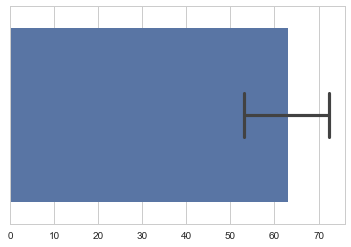

In [93]:
sns.barplot(x=["LSTM", "Simple RNN", "GRU"], data=df, capsize=.2)

So we can see that bost LSTM and GRU outperform the standard RNN. In average LSTM is slightly better than GRU but takes also more time to train.

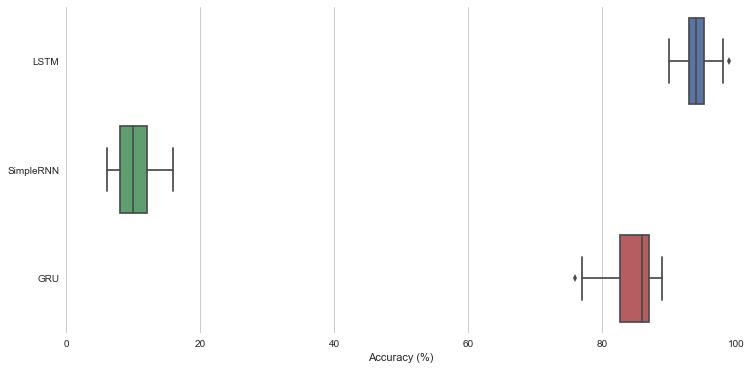

In [100]:
sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(12, 6))

ax = sns.boxplot(x=[result_LSTM, result_SRNN, result_GRU], y=["LSTM", "SimpleRNN", "GRU"])
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 100), ylabel="",
       xlabel="Accuracy (%)")
sns.despine(left=True, bottom=True)
plt.savefig("boxplot.png")
plt.show()

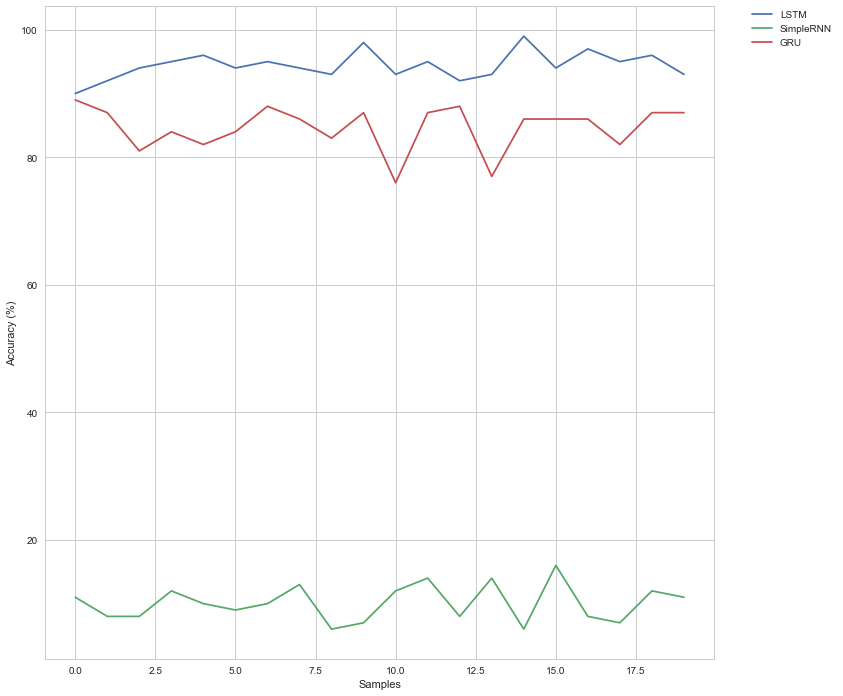

In [101]:
x = list(range(nb_samples))
y = [result_LSTM, result_SRNN, result_GRU]
labels = ["LSTM", "SimpleRNN", "GRU"]

plt.figure(figsize=(12, 12))
for y_arr, label in zip(y, labels):
    plt.plot(x, y_arr, label=label)

plt.xlabel("Samples")
plt.ylabel("Accuracy (%)")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig("test_result.png")
plt.show()

## Conclusion

In this workbook, we started to go through RNN. We check a simple model of both LSTM, GRU and SimpleRNN to check how fast and well they learn. On this example GRU and LSTM outperform the standard RNN due to the memory function. There is also a difference between LSTM and GRU but with slightly more epochs, they both perform similar. We can probably have better result by using a more advanced model but for such a simple model, we can see that it works really well.

## Going further

On a future notebook, we will explore Embedded Reber but using deeper RNNs